### Importing Libraries

In [16]:
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
# from functions import *
print("Packages imported")

Packages imported


### HOG Features and Visualisation

The technique counts occurrences of gradient orientation in localized portions of an image.
The code for extracting HOG features from an image is defined by the method get_hog_features and is contained in the cell titled "Define Method to Convert Image to Histogram of Oriented Gradients (HOG)." 


In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Function for Spatial Binning

In [3]:
# Define a function to compute binned color features  
#def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
#    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
#    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

### Function for color features

In [4]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# I opted to get rid of bin range altogether and let it be automatic
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Function to extract features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                #print('converting to YCrCb')
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Function to draw bounding boxes

In [7]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Sliding window function

In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

304
125
54
8
Windows Final 491


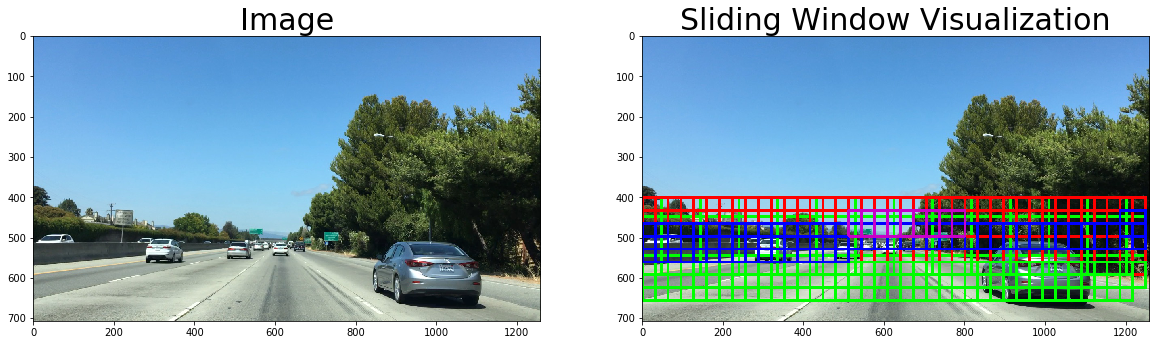

In [88]:
image = cv2.imread('bbox-example-image.jpg')
#image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

xy_window = [(64,64), (96,96), (128,128), (256,256)]
y_start_stop = [[400, 700], [400, 700], [400, None], [400, None]]
colors = [(255,0,0),(0,255,0),(0,0,255),(200,0,200)]
windows_temp = []
for i in range(len(xy_window)):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                        xy_window=xy_window[i], xy_overlap=(0.5, 0.5))
    print(len(windows))
    windows_temp.append(windows) 
    
sizes = [190,75,54,8]
#Flatten windows_temp
windows_final = sum(windows_temp, [])
offset = 0
for i,off in enumerate(sizes):
    bboxs = windows_final[offset:offset+off]
    for bbox in bboxs:
        cv2.rectangle(window_img, bbox[0], bbox[1], colors[i], 6)
    
    offset = off
print("Windows Final",len(windows_final))
   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)
ax2.imshow(window_img)
ax2.set_title('Sliding Window Visualization', fontsize=30)

### Function to extract features from a single image window

In [63]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            #print('converting to YCrCb')
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return (np.concatenate(img_features)), hog_image
    else:
        return np.concatenate(img_features)

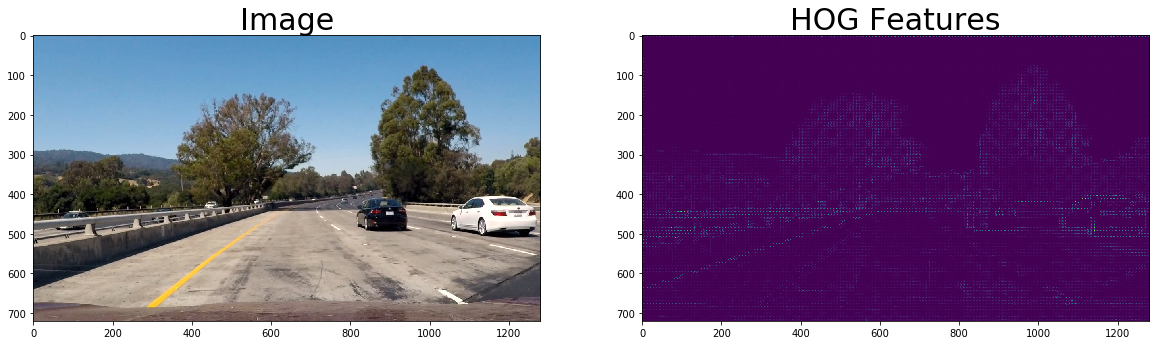

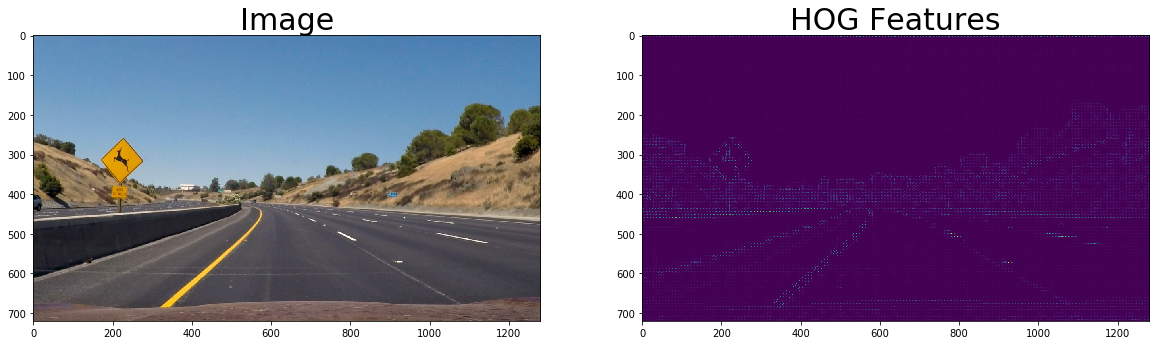

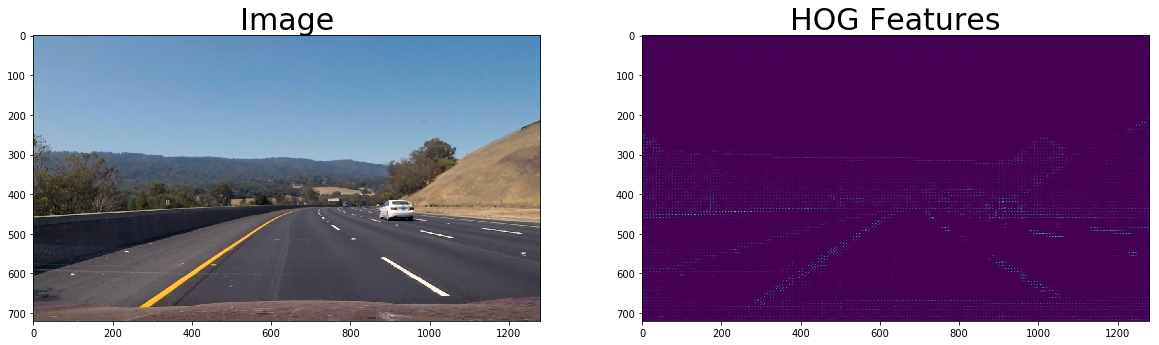

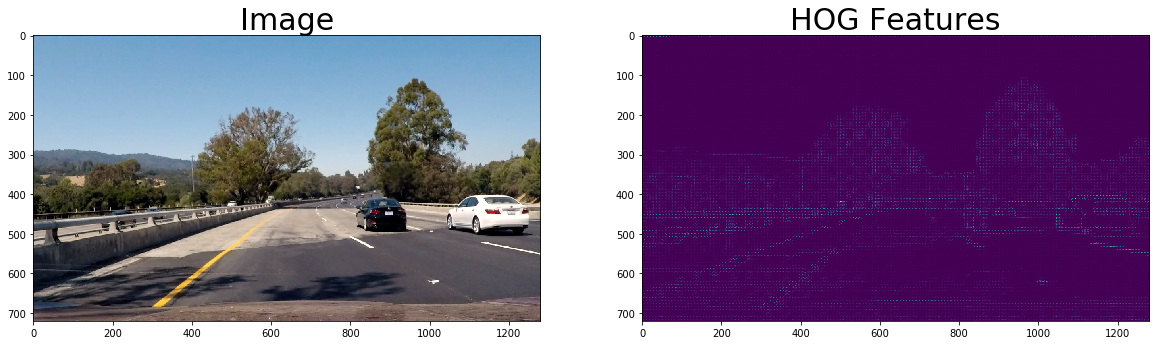

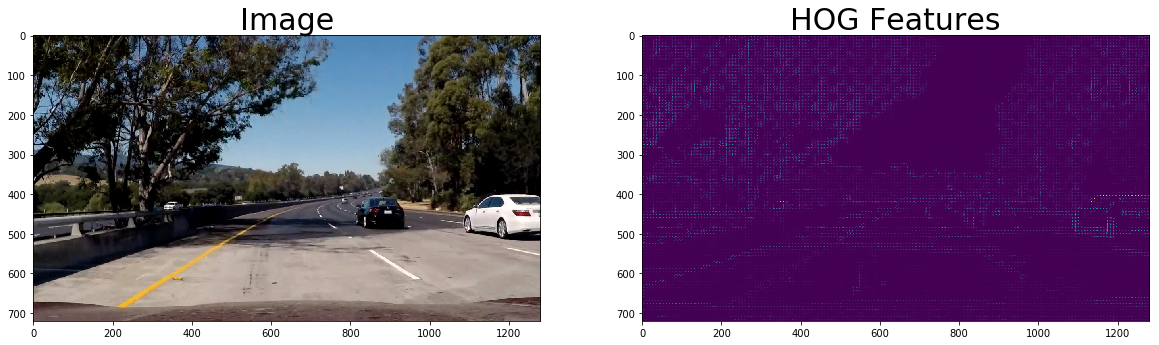

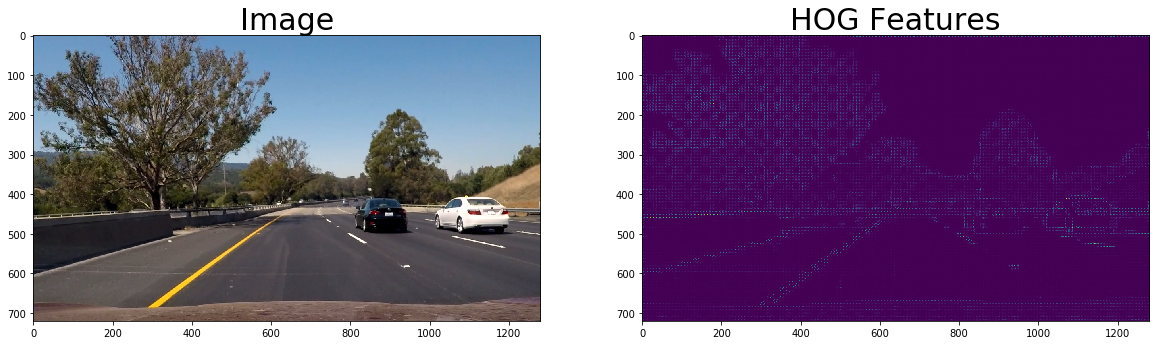

In [68]:
example_images = glob.glob('test_images/test*.jpg')
for i,img in enumerate(example_images):
    img = mpimg.imread(img)
    dst = (img)
    feat, hogimg = single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True, vis=True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Image', fontsize=30)
    ax2.imshow(hogimg)
    ax2.set_title('HOG Features', fontsize=30)


In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [10]:
# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [11]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

In [12]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [13]:
def draw_labeled_bboxes(img, carlist):
    # Iterate through all detected cars
    for car_number in range(len(carlist)):

    	if carlist[car_number].detected:
    		bbox = carlist[car_number].Box()
    		# Draw the box on the image
    		cv2.rectangle(img, bbox[0], bbox[1], (38, 133, 197), 6) 
    # Return the image
    return img

In [19]:
# read in cars and notcars
cars = glob.glob('training_data/vehicles/*/*.png')
notcars = glob.glob('training_data/non-vehicles/*/*.png')

# check that arrays are not empty
print(cars[0])
print(notcars[0])

training_data/vehicles\GTI_Far\image0000.png
training_data/non-vehicles\Extras\extra1.png


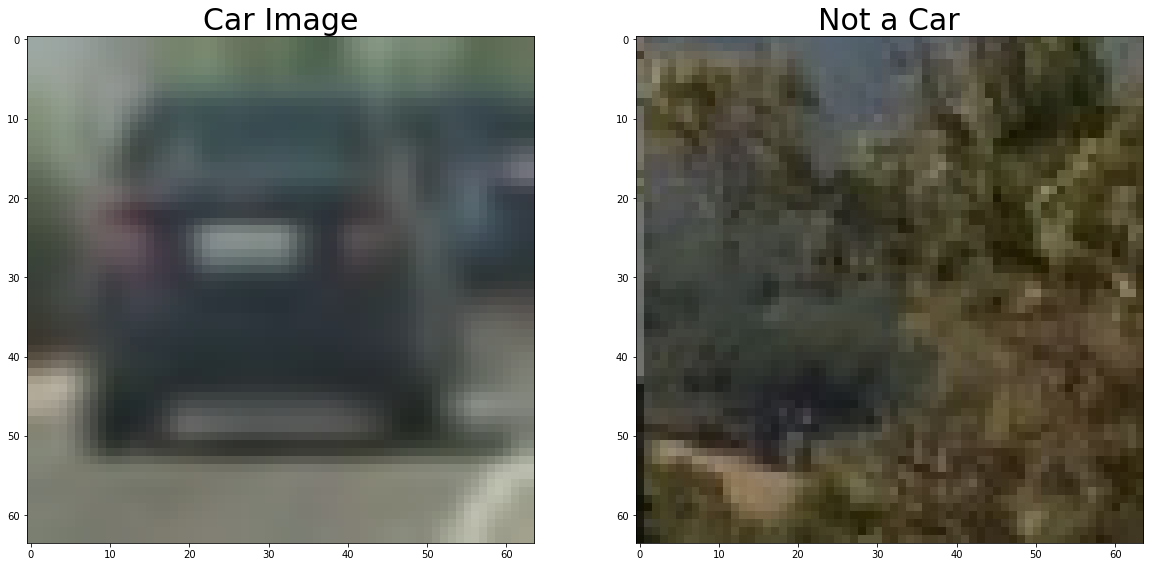

In [20]:
car = mpimg.imread(cars[0])
nocar = mpimg.imread(notcars[1])
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(nocar)
ax2.set_title('Not a Car', fontsize=30)

In [21]:
print("Number of Vehicle Images Found: ",len(cars))
print("Number of Non-Vehicle Images Found: ",len(notcars))

Number of Vehicle Images Found:  8792
Number of Non-Vehicle Images Found:  8968


In [22]:
# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

Car image:  6736
Not Car image:  3505


C:\Users\anu_d\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


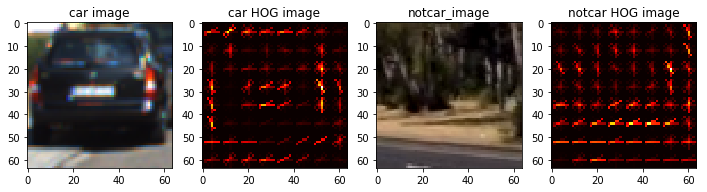

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# choose random car - not random car indices
car_ind = np.random.randint(0, len(cars))
print("Car image: ",car_ind)
notcar_ind = np.random.randint(0, len(notcars))
print("Not Car image: ",notcar_ind)

# read in car - not car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# define feature parameters
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=True)

    

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize=(12, 3))            
visualize(fig, 1, 4, images, titles)

In [24]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off   

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell,', cell_per_block,'cells per block,',
     hist_bins,'histogram bins, and', spatial_size,'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

svc_dict = {'svc':svc, 'scaler':X_scaler, 'orient':orient, 'pix_per_cell':pix_per_cell, 
            'cell_per_block':cell_per_block, 'spatial_size':spatial_size, 'hist_bins':hist_bins}
pickle.dump(svc_dict, open("pickle.p", "wb" ) )

C:\Users\anu_d\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


71.3072395324707 Seconds to compute features...
Using: 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
8.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


In [39]:
# Main class to generate video output

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2



# Load up saved data from SVM post training
dist_pickle = pickle.load( open("pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

# Define the y range to search for cars
ystart = 400
ystop = 656
# Save off heatmaps and car detected
heatmaps = []
carslist = []

# Function used to sync new detections with existing saved car detections
def Sync(captured, carlist):


    #print('used for debugging: start sync')
    #print('caps ',len(captured))
    #print('cars ',len(carlist))

    # If no cars add any detections as a new vehicle and put in carlist
    if len(carlist) == 0:
        for capture in captured:
            carlist.append(vehicle(capture[0],capture[1],capture[2],capture[3]))
    # If no captures but carlist is not empty then demote all vehicle detections
    elif len(captured) == 0:
        for car in carlist:
            if car.NegUpdate():
                carlist.remove(car)

    # Both carlist and new detections are non-empty and need to do comparisons to pair results
    else:
        # Keep track of what captures need to be made into a new vehicle
        capture_update = np.zeros((len(captured)))
        # Keep track of what cars need to get demoted because they didnt have a new track
        remove_update = np.zeros((len(carlist)))
        # Create a table to keep track of how new captures and existing captures relate
        # new captures are stored on the rows and exisitng captures on the columbs
        # The values we are storing between a new/old caputre pair is the rank defined as distance between positions
        grid = np.zeros((len(captured),len(carlist)+1))

        # Iterate through new captures
        for x in range(len(captured)):
            # Iterate through old captures
            for o in range(len(carlist)):
                # Measure the distance between new capture and all old captures
                grid[x,o] = carlist[o].Rank(captured[x][0],captured[x][1])
            # Store the old capture that was closest to the new capture 
            grid[x,len(carlist)] = np.argmin(grid[x][:-1])
        # Iterate through old captures
        for o in range(len(carlist)):
            # Iterate through new captures
            for x in range(len(captured)):
                # Mark all ranks as very high if new/old capture pair didnt match
                if grid[x][-1] != o:
                    grid[x,o] = 1000

            # If the rank is good between new/old capture pair
            if np.amin(grid[:,o]) < 1000:
                # Establish a link to new/old capture and update new detected positon and window dimensions
                get_capture = captured[np.argmin(grid[:,o])]
                carlist[o].PosUpdate(get_capture[0],get_capture[1],get_capture[2],get_capture[3])
                capture_update[np.argmin(grid[:,o])] = 1
            else:
                # Else old capture did not have a new capture
                remove_update[o] = 1
        # Check what new captures did not have a matched old capture and create a new vehicle out of it, and add it in carlist
        for i in range(len(capture_update)):
            if capture_update[i] == 0:
                get_capture = captured[i]
                carlist.append(vehicle(get_capture[0],get_capture[1],get_capture[2],get_capture[3]))

        # Look through old captures that did not have a new capture and demote them, if the negtative detections in a row is
        # greater than some threshold we delete the old capture from the carlist
        remove_index = []
        for car in range(len(remove_update)):
            if remove_update[car] == 1 and carlist[car].NegUpdate():
                remove_index.append(car)

        carlist = np.delete(carlist,remove_index)
        carlist = carlist.tolist()
    return carlist

# Process each frame of the video
def process_image(image):
    # We want to modify carslist and heatmaps from this function
    global carslist, heatmaps
    # Create a general heatmap
    heatmap = np.zeros_like(image[:,:,0])
    # Iterate through different scale values
    for scale in np.arange(1,2.1,.2):
        # Create heat maps for different scales in function to both search and classify
        out_img, heat_map = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Add heat to heatmap from different scales
        heatmap += heat_map

    # Add general heatmap to list of heatmaps
    heatmaps.append(heatmap)
    # Sum togehter the last 5 frame heatmaps into 1 heatmap
    heatmap = seriesHeatmap(image,5)
    # Use threshold to help remove false positives from heatmap
    heatmap = apply_threshold(heatmap,5)
    # Get the box positions from heatmap
    labels = label(heatmap)

    # Store box parameters for each box as a new capture
    captured = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        xpos = np.min(nonzerox)
        ypos = np.min(nonzeroy)

        width = np.max(nonzerox)-xpos
        height = np.max(nonzeroy)-ypos

        captured.append([xpos,ypos,width,height])

    # Sync old captures with new captures
    carslist = Sync(captured,carslist)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(image), carslist)

    return draw_img

def draw_labeled_bboxes(img, carlist):
    # Iterate through all detected cars
    for car_number in range(len(carlist)):

        if carlist[car_number].detected:
            bbox = carlist[car_number].Box()
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 5) 
    # Return the image
    return img

def seriesHeatmap(refimg,nframe):
    heatmap = np.zeros_like(refimg[:,:,0])
    nframe = min(5,len(heatmaps))
    for i in np.arange(1,nframe):
        heatmap += heatmaps[-i]
    return heatmap


video_output = 'track1.mp4'
Input_video = 'test_video.mp4'
clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video track1.mp4
[MoviePy] Writing video track1.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:32<00:03,  3.99s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: track1.mp4 



In [44]:
import math
import numpy as np

class vehicle():
    def __init__(self, x_position, y_position, width, height, smooth_factor=5):
        self.detected = False  # is vehicle active, only draw vehicle if active
         # Store all vehciles history of x,y positions and width/height
        self.x_positions = []
        self.x_positions.append(x_position)
        self.y_positions = []
        self.y_positions.append(y_position)
        self.width = []
        self.width.append(width)
        self.height = []
        self.height.append(height)
        # Define a smoothing factor to average past x,y positions and width/height
        self.smooth_factor = smooth_factor

        self.n_detections = 1 # Number of consecutive times this vehicle has been detected?
        self.n_nondetections = 0 # Number of consecutive times this car has not been detected since last detection
    
    # Return the distance between the vehicles position and some input capture's position
    def Rank(self, x_position, y_position):
        rank = math.sqrt((x_position-self.x_positions[-1])**2+(y_position-self.y_positions[-1])**2)
        # threshold the max distance to consider a link
        if rank < 50: 
            return rank
        else:
            return 1000

    # Update the vehicle with new pos/dim
    def PosUpdate(self, x_position, y_position, width, height):
        self.x_positions.append(x_position)
        self.y_positions.append(y_position)
        self.width.append(width)
        self.height.append(height)

        self.n_detections+=1
        self.n_nondetections = 0
        if self.n_detections > 5:
            self.detected = True

    # Demote the vehicle because it didnt have a new caputre
    def NegUpdate(self): #return weather to remove vehicle
        self.n_nondetections+=1

        # If we dont see the vehicle for three frames in a row we delete it
        if self.n_nondetections > 3:
            return True
        return False

    # Check if vehicle was detected but had failed to be tracked 3 times in a row
    def CheckValid(self):
        if self.detected & self.n_nondetections > 3:
            return False
        else:
            return True

    # Average together all pos/dim and return the box that defines
    def Box(self):
        xpos = int(np.average(self.x_positions[-self.smooth_factor:], axis = 0))
        ypos = int(np.average(self.y_positions[-self.smooth_factor:], axis = 0))
        width = int(np.average(self.width[-self.smooth_factor:], axis = 0))
        height = int(np.average(self.height[-self.smooth_factor:], axis = 0))

        return ((xpos, ypos), (xpos+width, ypos+height))

In [59]:
# Process each frame of the video
def process_img(image):
    # We want to modify carslist and heatmaps from this function
    global carslist, heatmaps
    # Create a general heatmap
    heatmap = np.zeros_like(image[:,:,0])
    # Iterate through different scale values
    for scale in np.arange(1,2.1,.2):
        # Create heat maps for different scales in function to both search and classify
        out_img, heat_map = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Add heat to heatmap from different scales
        heatmap += heat_map

    # Add general heatmap to list of heatmaps
    heatmaps.append(heatmap)
    # Sum togehter the last 5 frame heatmaps into 1 heatmap
    heatmap = seriesHeatmap(image,5)
    # Use threshold to help remove false positives from heatmap
    heatmap = apply_threshold(heatmap,5)
    # Get the box positions from heatmap
    labels = label(heatmap)

    # Store box parameters for each box as a new capture
    captured = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        xpos = np.min(nonzerox)
        ypos = np.min(nonzeroy)

        width = np.max(nonzerox)-xpos
        height = np.max(nonzeroy)-ypos

        captured.append([xpos,ypos,width,height])

    # Sync old captures with new captures
    carslist = Sync(captured,carslist)

    # Draw bounding boxes on a copy of the image
    # 	draw_img = draw_labeled_bboxes(np.copy(image), carslist)

    return (heatmap)

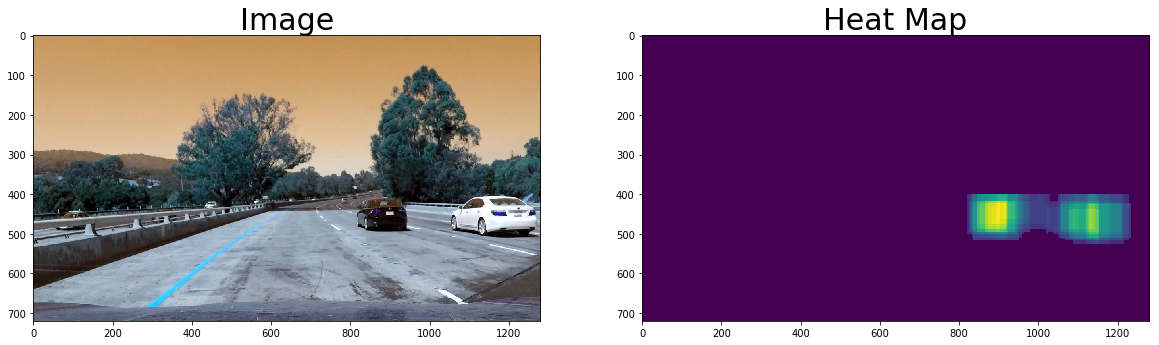

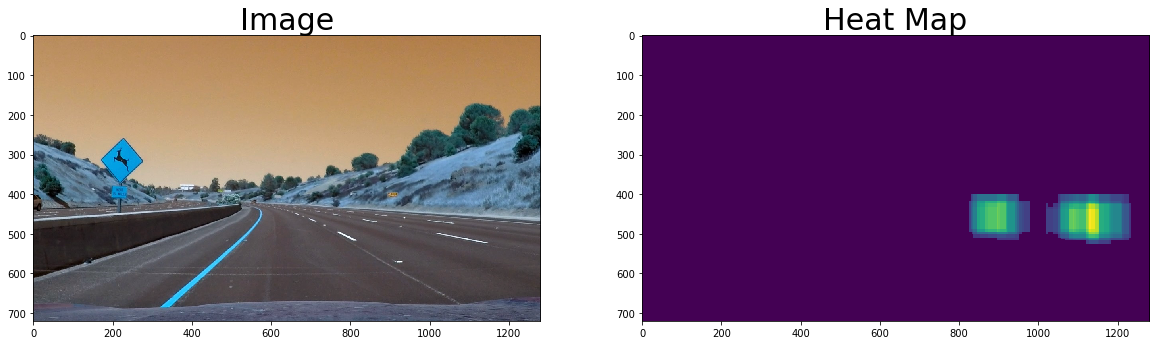

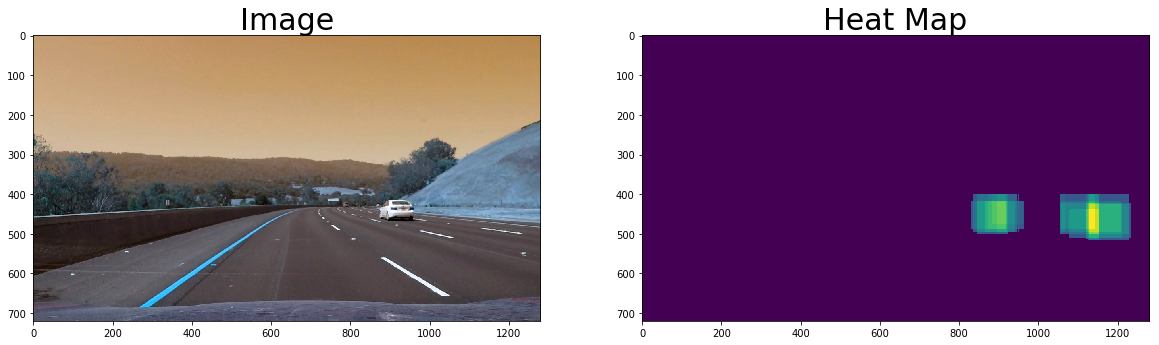

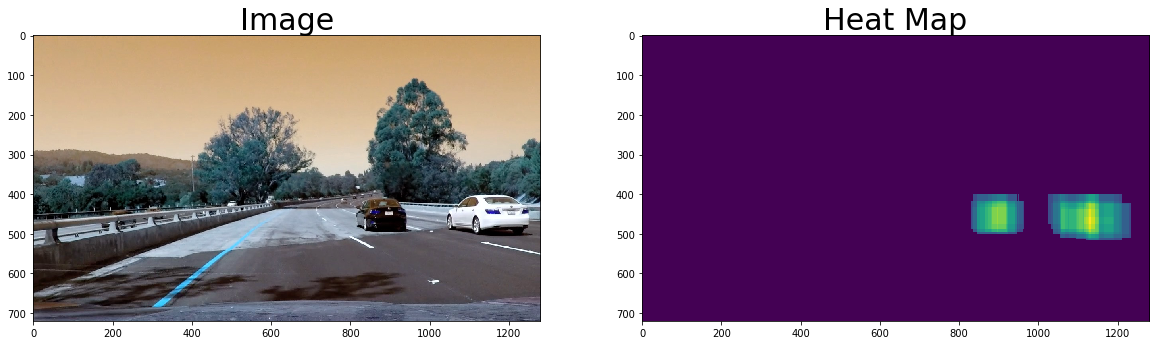

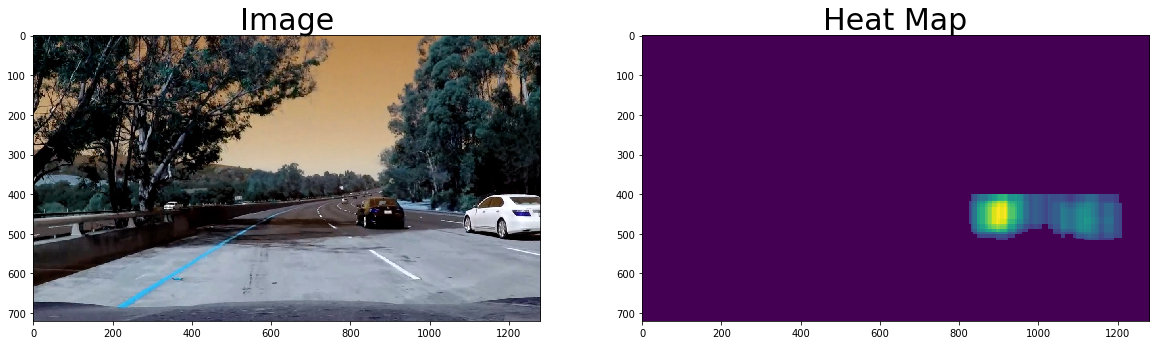

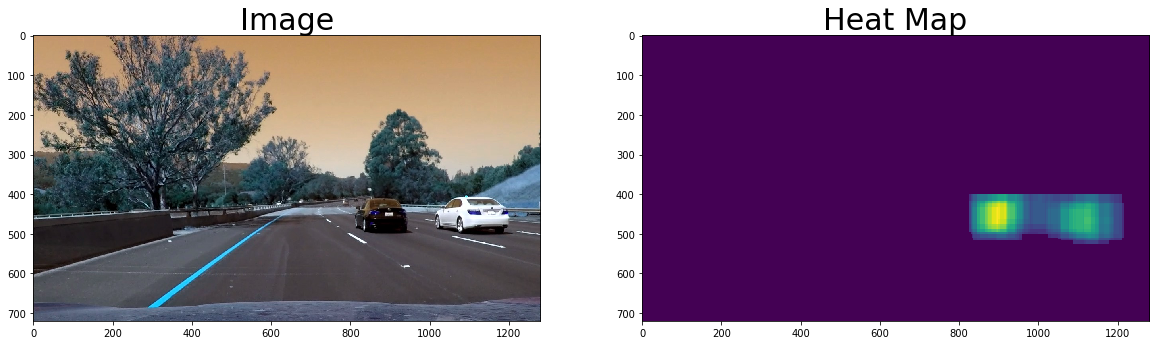

In [61]:
# Main class to generate image output

import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog
import os, os.path
import pickle


# Load up saved data from SVM post training
dist_pickle = pickle.load( open("pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

example_images = glob.glob('test_images/test*.jpg')

# Define the y range to search for cars
ystart = 400
ystop = 656


for i,img in enumerate(example_images):
    img = cv2.imread(img)
    heatmap = process_img(img)
    #Save the output for car box locations and heatmaps
#     write_name = 'output_images/tracked'+str(i)+'.jpg'
#     cv2.imwrite(write_name, img)

#     write_name = 'output_images/heatmap'+str(i)+'.jpg'
#     cv2.imwrite(write_name, heatmap*20)
#     plt.imshow(heatmap)
#     #plt.imshow(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Image', fontsize=30)
    ax2.imshow(heatmap)
    ax2.set_title('Heat Map', fontsize=30)